## Imports and setups

Substitute variables with appropriate file paths/selections

In [ ]:
python_files_folder = '/Users/isaacdaviet/Desktop/thesis/python_versions' # replace with directory containing the .py calculation files below
import sys
sys.path.append(python_files_folder)

import SPACE2_replotting as replot
import os
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# python_files_folder = '/Users/isaacdaviet/Desktop/thesis/python_versions'

# import sys
# sys.path.append(python_files_folder)
# import SPACE2_replotting as replot
# import pandas as pd
# import os

# import importlib
# importlib.reload(replot)


## Link SPACE2 Configurations to associated labeled sequences

Extract all SPACE2 structural configurations/clusters and their associated ISEQS and assign them to a modified labeled sequences dataframe containing sequences, labels, and iseq number. Extracts the SPACE2 summary sheet from each reduction excel file in the space2 cluster folder and adds all SPACE2 clusters to the matching ISEQs/sequences in the UMAP_df.

### For PCA derived clusters:

In [ ]:
pca_space2_results_xl = r'/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/mason_PCA_manual_clusters_SPACE2_agglomerative_1-25_REDO_min.xlsx'
# PCA summary xl file
pca_coord_csv = r'/Users/isaacdaviet/Desktop/results/PCA_analysis/mason-PCAdf95.csv'
# PCA reduction file containing coordinates for all points across all components

save_file = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/PCA_clusters_by_reduction.xlsx'
# Include .xlsx extension



df_dict = replot.generate_all_cluster_excel('PCA', pca_space2_results_xl, pca_coord_csv, save_file)

### For UMAP Derived Clusters

#### Generate Dataframes Dictionary

Iterates through all reduction and SPACE2 results files to produce unique dataframe for each reduction and compiles them into a dictionary.
Process can be fairly computationally intensive, so the resulting dictionary is saved as an excel file in order to avoid repeating the entire process if the dictionary is lost 

In [ ]:
space2_clusters_folder = r'/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/structural_clusters'
# folder with files containing SPACE2 configuration clusters
dimred_csv_folder = r'/Users/isaacdaviet/Desktop/results/clustering/UMAP_dbscan_clusters'
# folder containing reduction coordinate files

exclude_files = ['umap_all_summaries.xlsx', 'mason_umap_clustering_analysis_binders.csv']
# Include as list all files included in above folders that are not the SPACE2 configuration results or the reduction files (eg: the all_summaries.xlsx file that is usually saved with the SPACE2 results files)

save_file = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/UMAP_clusters_by_reduction.xlsx'
# full file path + name, including .xlsx extension


df_dict = replot.generate_all_cluster_excel('UMAP', space2_clusters_folder, dimred_csv_folder, save_file, exclude_files)

## Convert clusters_by_reduction excel file back to dictionary

If the df_dict from the previous section is lost, use this function to reload it from the saved excel file.

NOTE: the function in the next section can take either the df_dict or the file path to the saved excel a an input, so this section is only necessary if desire to examine/edit/process differently the file

In [ ]:
cluster_by_reduction_file = r'/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/UMAP_clusters_by_reduction.xlsx'
df_dict = replot.get_df_dict_from_excel(cluster_by_reduction_file)

## Calculate unique SPACE2 cluster and superclusters of sequences

Uses excel file of df_dict from previous section to generate 2 new csvs. 

First csv contains the labels dataframe with sequence, label, iseq columns as well as all unique clusters for each UMAP distance metric, the number of unique clusters for each + unique cluster & count in the entire row.

Second csv is a dataframe of the same format as the first, but with the unique clusters IDed in the cells of the first dataframe clustered again in SPACE2 to determine if they should be considered part of the same structural (super)cluster.

This section exists to simplify the naming of the structural configurations so that they can be easily mapped back onto the original reductions. This is necessary as SPACE2 names the configuration according to the first PDB file it analyzes in a given cluster, which can vary slightly based on the the reduction.

In brief:
>...space2_clusters-by-seq.csv contains all unique SPACE2 clusters identified with each metric by SPACE2 assigned to their appropriate sequence

>...space2_superclusters.csv contains the resulting superclusters when these lists are run through SPACE2 again assigned to their appropriate sequence

NOTE: For the use of the Mason dataset, all sequences were confirmed to have a single associated supercluster. The codes in the next sections reflect that fact and may have to be updated should future datasets not return such results.
These were also not run again through SPACE2 to thin the number of cluster further, although doing so could be interesting for future wor/refinement of the workflow

In [ ]:
reduction_type = 'PCA'
# Reduction method being analyzed. 'PCA' or 'UMAP'

xl_file_or_df_dict = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/PCA_clusters_by_reduction.xlsx' 
# df_dict variable OR excel file path generated in previous section. 


igfold_outfile = r'/Users/isaacdaviet/Desktop/mason_igfold_models/mason_igfold_models/igfold_outfile'
# Folder containing PDB files of al sequences

save_folder = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting'

### SPACE2 parameters for configurational supercluster identification
#### Recommend setting SPACE2 parameters to same values as initial clustering
cdr_selection = ["CDRH3"]
chain_selection = ['fwH']
rmsd_threshold = 1.25 # Recommended default of 1.25
algorithm = "agglomerative"
n_jobs = 1 # Recommended default of 1




cl_seq_df = replot.generate_unique_clusters_df(reduction_type, xl_file_or_df_dict) 
cl_seq_df.to_csv(os.path.join(save_folder, 'mason_pca-space2_clusters-by-seq.csv'), index = False)
print('SAVING mason_umap-space2_clusters-by-seq.csv')

super_df=replot.find_superclusters(cl_seq_df, igfold_outfile, cdr_selection, chain_selection, rmsd_threshold, n_jobs)
super_df.to_csv(os.path.join(save_folder, 'mason_pca-space2_superclusters.csv'), index = False)
print('SAVING mason_umap-space2_superclusters.csv')

### Simple QC of Configurational Superclusters

Will print total number of superclusters for all, binders-only and non binders-only sequences for all reductions.

In [ ]:
super_df_csv = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/mason_pca-space2_superclusters.csv'
# csv file of configurational superclusters (...space2_superclusters.csv file generated from previous section)



super_df=pd.read_csv(super_df_csv)

binder_sdf =super_df[super_df['Labels']== 'Binder']
non_binder_sdf = super_df[super_df['Labels']== 'Non Binder']

columns = super_df.columns.unique().tolist()[3:]

for i in range(0, len(columns)):
    if i % 2 == 0 or i == 0:
        column = columns[i]
        all_unique = list(filter(None, super_df[column].unique().tolist()))
        binders_unique = list(filter(None, binder_sdf[column].unique().tolist()))
        non_binders_unique = list(filter(None, non_binder_sdf[column].unique().tolist()))

        print(column)
        print(f'Total number of SPACE2 clusters {len(all_unique)}')
        # print(all_unique)

        print(f'Number of SPACE2 BINDER clusters {len(binders_unique)}')
        # print(binders_unique)

        print(f'Number of SPACE2 NON BINDER clusters {len(non_binders_unique)}\n\n\n')
        # print(non_binders_unique,'\n\n\n')


## Plot each reduction by SPACE2 configurational supercluster

Section replots SPACE2 configurational superclusters back onto existing UMAP or PCA plots. First two sections will replot all reductions in a given folder and provide a png image with a number of subplots of different coloring.

>-The n_metric input determines what number of metrics need to have confirmed a supercluster for a given sequence/point in order for it to be plotted in a series of graphs. Please note that, as this code generates images for exploratory reasons, a number of the subplots generated will be a n_metric = 1, therefore setting n_metric to 1 is unecessary. Recommend to run set the value at 3 (>50% of metrics identified the supercluster) or 5 (all metrics identified the supercluster)

>-the cluster_column variable determines the which metric clusters will be used in the plotting (ie: only clsuters identified by the specific metric listed in the column, or the clusters determined in the 'all_metrics' column).

### Replotting individual UMAP or PCA reductions

In [ ]:


pca_superclusters_csv='/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/SPACE2_cluster_replotting/mason_pca-space2_superclusters.csv'

pca_clusters_by_reduction = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/SPACE2_cluster_replotting/PCA_clusters_by_reduction.xlsx'


umap_superclusters_csv = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/mason_umap-space2_superclusters.csv'

umap_clusters_by_reduction = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/UMAP_clusters_by_reduction.xlsx'


save_folder ='/Users/isaacdaviet/Desktop/'


reduction_type = 'PCA'
replot_to = 'PCA'
n_pcs_or_metrics = 5

supercluster_column = 'all_SPACE2_clusters'

reduction_sheet_name = 'PCA1-2'
# reduction_sheet_name = 'cosine-5-95-0.0-4-5'
title = 'test'

subtitle_size= 60




superclusters_csv = umap_superclusters_csv if reduction_type == 'UMAP' else pca_superclusters_csv

clusters_by_reduction = umap_clusters_by_reduction if replot_to == 'UMAP' else pca_clusters_by_reduction

save_file =(os.path.join(save_folder, f'{title}.png'))

spcl_df = pd.read_csv(superclusters_csv)

single_reduction_df = pd.read_excel(clusters_by_reduction, sheet_name = reduction_sheet_name)


replot.replot_by_supercluster(reduction_type, replot_to, spcl_df, single_reduction_df, supercluster_column, n_pcs_or_metrics,  title, save_file, subtitle_size =subtitle_size, legend=True)


KeyError: 'PCA_clusters'

### Plotly cluster explroation

Replots UMAP or PCA structural superclusters to original UMAP or PCA reductions. Can be used in iterative fashion to generate all graphs at a time. To be used for exploratory purposes, generates 2 graphs, one for binders only, one for non binders. Ignore buttons in graphs, they don't seem to work properly, except maybe the priority buttons in UMAP graphs.

Use to identify one or two plots of interest that can then be combined to generate new dataframe for final png generation in matplotlib in next section.

In [ ]:
python_files_folder = '/Users/isaacdaviet/Desktop/thesis/python_versions' # replace with directory containing the .py calculation files below
import sys
sys.path.append(python_files_folder)
import importlib
import SPACE2_replotting as replot

# Reload the module
importlib.reload(replot)

pca_superclusters_csv='/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/mason_pca-space2_superclusters.csv'

pca_clusters_by_reduction = pca_df_dict

pca_save_folder ='/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/replot_PCAtoPCA'




umap_superclusters_csv = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/mason_umap-space2_superclusters.csv'

umap_clusters_by_reduction = umap_df_dict

umap_save_folder = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/replot_UMAPtoUMAP'

reduction_type = 'PCA'
replot_to = 'UMAP'

n_pcs = 5
n_metrics = 5

pca_supercluster_column_name = 'all_SPACE2_clusters'

umap_supercluster_column_name = 'all_SPACE2_clusters'


umap_focused_metric = None
pca_focused_component = None


umap_clusters_by_reduction = replot.get_df_dict_from_excel(umap_clusters_by_reduction) if type(umap_clusters_by_reduction)==str else umap_clusters_by_reduction

if umap_focused_metric is not None and replot_to == 'UMAP':
    metric_filtered_umap_df_dict = {}


    for reduction, df in umap_clusters_by_reduction.items():
        if umap_focused_metric in reduction:
            metric_filtered_umap_df_dict[reduction] = df

else:
    metric_filtered_umap_df_dict = umap_clusters_by_reduction

cluster_by_reduction = metric_filtered_umap_df_dict if replot_to == 'UMAP' else pca_clusters_by_reduction

save_folder = umap_save_folder if replot_to == 'UMAP' else pca_save_folder

df_dict = replot.replot_all_to_plotly(reduction_type, replot_to, umap_superclusters_csv, cluster_by_reduction, n_metrics, umap_supercluster_column_name, save_folder, dataset_name = 'Mason', SPACE2_algorithm = 'agglomerative', min_rmsd = 1.25, n_jobs = 1)



# Generate final plots for presentation

### generate dataframe

IMPORTANT NOTE REGARDING FUTURE WORK!!!!

Look to creating MEGA dataframe and csv file containing all the information for each sequence

In [ ]:
original_labels_files = '/Users/isaacdaviet/Desktop/mason_igfold_models/mason_sequences_label.csv'

umap_reduction_of_interst_csv = '/Users/isaacdaviet/Desktop/results/clustering/UMAP_dbscan_clusters/correlation_clusters/csv_files/UMAP_Mason-correlation-3-25-0.0-1-2_dbscanClusters-0.15-20.csv'


umap_component1_column_name = 'UMAP-1'
umap_component2_column_name = 'UMAP-2'

umap_superclusters_csv = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/UMAP_reductions/SPACE2_cluster_replotting/mason_umap-space2_superclusters.csv'

umap_supercluster_column_name = 'correlation_unique_clusters'



pca_reduction_csv = '/Users/isaacdaviet/Desktop/results/PCA_analysis/mason-PCAdf95.csv'

pca_superclusters_csv = '/Users/isaacdaviet/Desktop/results/SPACE2_analysis/PCA_manual_clusters/Redo/SPACE2_cluster_replotting/mason_pca-space2_superclusters.csv'

pca_supercluster_column_name = 'all_SPACE2_clusters'

pca_component1_column_name = 'PCA2_ExpVar:4.47%'

pca_component2_column_name = 'PCA4_ExpVar:3.99%'

In [ ]:


umap_spcl_df = pd.read_csv(umap_superclusters_csv)
umap_reddf = pd.read_csv(umap_reduction_of_interst_csv)

og_labels_df = pd.read_csv(original_labels_files)

pca_spcl_df = pd.read_csv(umap_superclusters_csv)
pca_reddf = pd.read_csv(pca_reduction_csv)

new_df_cols = ['sequence', 'label','umap_c1', 'umap_c2', 'umap_spcl_seqs', 'umap_red_seqs', 'umap_superclusters', 'umap_priority', 'pca_c1', 'pca_c2', 'pca_seqs', 'pca_red_seqs', 'pca_superclusters']

new_df = pd.DataFrame(columns = new_df_cols)


for index, row in og_labels_df.iterrows():
    # Construct a new row as a list or dictionary (better when you know column names)
    seq = row['sequence']

    umap_spcl_row = umap_spcl_df[umap_spcl_df['Sequences'] == seq]
    umap_red_row = umap_reddf[umap_reddf['Sequences'] == seq]
    pca_spcl_row = pca_spcl_df[pca_spcl_df['Sequences'] == seq]
    pca_red_row = pca_reddf[pca_reddf['Sequences'] == seq]

    new_row_data = {
        'sequence': seq,
        'label': umap_spcl_row['Labels'].iloc[0],
        'umap_c1': umap_red_row[umap_component1_column_name].iloc[0] if not umap_red_row.empty else None,
        'umap_c2': umap_red_row[umap_component2_column_name].iloc[0] if not umap_red_row.empty else None,
        'umap_spcl_seqs': umap_spcl_row['Sequences'].iloc[0] if not umap_spcl_row.empty else None,
        # Add the rest similarly...
        'umap_red_seqs': umap_red_row['Sequences'].iloc[0] if not umap_red_row.empty else None,
        'umap_superclusters': umap_spcl_row[umap_supercluster_column_name].iloc[0] if not umap_spcl_row.empty else None,
        'umap_priority': umap_red_row['priority'].iloc[0] if not umap_red_row.empty else None,
        # Continue for PCA columns
        'pca_c1': pca_red_row[pca_component1_column_name].iloc[0] if not pca_red_row.empty else None,
        'pca_c2': pca_red_row[pca_component2_column_name].iloc[0] if not pca_red_row.empty else None,
        'pca_seqs': pca_spcl_row['Sequences'].iloc[0] if not pca_spcl_row.empty else None,
        'pca_red_seqs': pca_red_row['Sequences'].iloc[0] if not pca_red_row.empty else None,
        'pca_superclusters': pca_spcl_row[pca_supercluster_column_name].iloc[0] if not pca_spcl_row.empty else None
    }

    # Append the row to the DataFrame
    new_row_df = pd.DataFrame([new_row_data])
    new_df = pd.concat([new_df, new_row_df], ignore_index=True)



In [ ]:
new_df['seq_match'] = (
    (new_df['sequence'] == new_df['umap_spcl_seqs']) &
    (new_df['sequence'] == new_df['umap_red_seqs']) &
    (new_df['sequence'] == new_df['pca_red_seqs']) &
    (new_df['sequence'] == new_df['pca_seqs'])
)


if not new_df['seq_match'].all():
    df_discrepancies = new_df[~new_df['seq_match']]
    raise ValueError(f"Inconsistencies detected in sequence order. Please check dataframe and original csv files\n\nDiscrepancies found in the following rows:\n\n{df_discrepancies}")

else:
    keep_cols = ['sequence', 'label','umap_c1', 'umap_c2', 'umap_superclusters', 'umap_priority', 'pca_c1', 'pca_c2', 'pca_superclusters']

    new_df = new_df[keep_cols]

### generate replots

/var/folders/1g/k389ttcx01l7s92rq9874q600000gn/T/ipykernel_98243/4279921259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df[color_col].replace('', pd.NA, inplace=True)


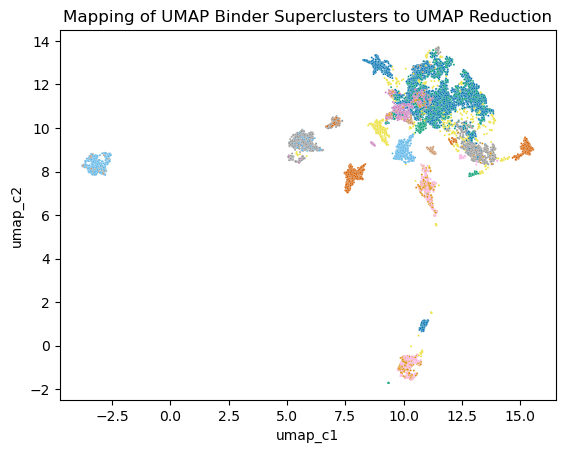

/var/folders/1g/k389ttcx01l7s92rq9874q600000gn/T/ipykernel_98243/4279921259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df[color_col].replace('', pd.NA, inplace=True)


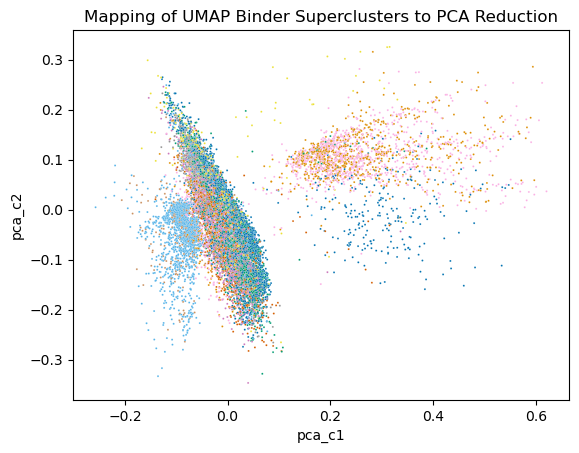

/var/folders/1g/k389ttcx01l7s92rq9874q600000gn/T/ipykernel_98243/4279921259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df[color_col].replace('', pd.NA, inplace=True)


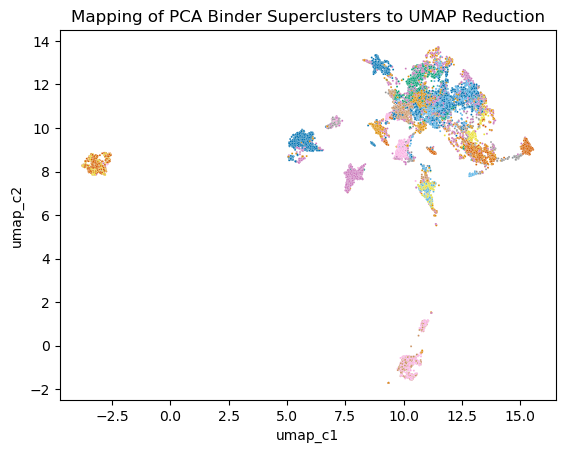

/var/folders/1g/k389ttcx01l7s92rq9874q600000gn/T/ipykernel_98243/4279921259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df[color_col].replace('', pd.NA, inplace=True)


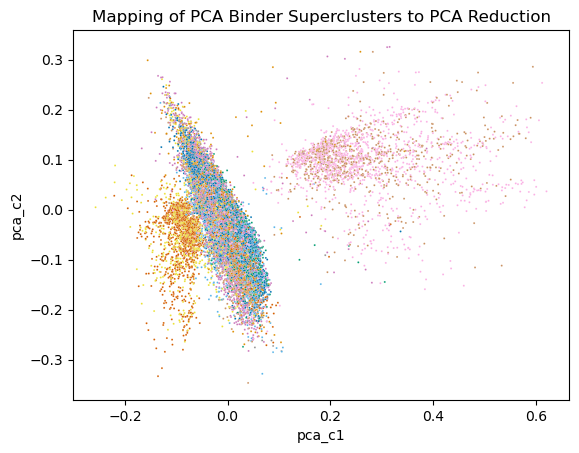

In [ ]:
umap_coord_cols = [umap_component1_column_name, umap_component2_column_name]
pca_coord_cols = [umap_component1_column_name, umap_component2_column_name]

umap_spcl_to_umap_cols = ['umap_c1', 'umap_c2', 'umap_superclusters']
umap_spcl_to_pca_cols = ['pca_c1', 'pca_c2', 'umap_superclusters']
pca_spcl_to_umap_cols = ['umap_c1', 'umap_c2', 'pca_superclusters']
pca_spcl_to_pca_cols = ['pca_c1', 'pca_c2', 'pca_superclusters']

all_graphs_col_list = [umap_spcl_to_umap_cols, umap_spcl_to_pca_cols, pca_spcl_to_umap_cols, pca_spcl_to_pca_cols]

# print_df = new_df[new_df['label'] == 'Binder']
print_df = new_df[new_df['label'] == 'Non Binder']

for graph in all_graphs_col_list:
    x = graph[0]
    y = graph[1]
    color_col = graph[2]

    print_df[color_col].replace('', pd.NA, inplace=True)
    cleaned_df = print_df.dropna(subset=[color_col])
    # cleaned_df = cleaned_df[cleaned_df['umap_priority'] == 'high']

    scatterplot = sns.scatterplot(data=cleaned_df, x=cleaned_df[x], y=cleaned_df[y], hue=color_col, palette='colorblind', legend=False, s=2)

    replot_to = 'PCA' if 'pca' in x else 'UMAP'
    spcl_type= 'PCA' if 'pca' in color_col else 'UMAP'

    plt.title(f'Mapping of {spcl_type} Binder Superclusters to {replot_to} Reduction')

    plt.show()
